This notebook was created by Donna Faith Go.

In [1]:
# import sys
# !{sys.executable} -m pip install cvxopt plotly cufflinks

# [Markowitz portfolio optimization](https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/?fbclid=IwY2xjawMo8clleHRuA2FlbQIxMQABHuyZdkuwk_uY9jgZoTi8l5EPdpAtEDekC4BmZpE0zILe1THV1r_8HoJgTA2K_aem_JoK2f6vaXhMcEpMEe0eu8Q)
Markowitz portfolio optimization is a financial model that helps investors construct portfolios that are most efficient in terms of risk and return.
The over-arching idea of the Markowitz optimmization is that investors shouldn't choose securities/stocks that move together so that they can minimize their risk.
Here, I tried to learn about this by simulating stock behavior.
The references I've used have been linked below.

In [2]:
%matplotlib inline
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import cufflinks
import matplotlib.pyplot as plt

# import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
solvers.options['show_progress'] = False

## Understanding the Theory

First, I will generate a set of returns for 4 stocks.

In [3]:
n_assets = 4
n_obs = 1000 # this is the number of observations
returns = np.random.randn(n_assets, n_obs) # should have a normal distribution

Now, let's plot the returns over time for the 4 assets.

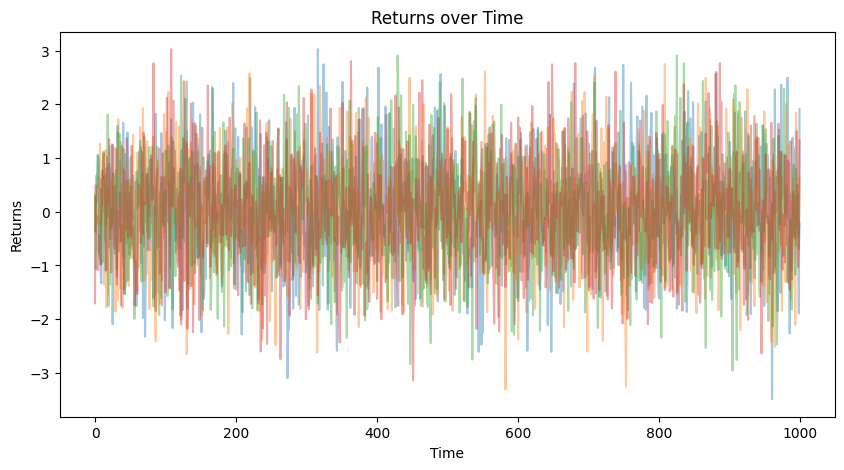

In [4]:
fig = plt.figure(figsize=(10, 5))
plt.plot(returns.T, alpha=0.4)
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Returns over Time')
plt.show()

Here, we used returns over time because this is a better way to observe stock performance rather than their raw price. 
Raw prices can vary drastically from one stock to another. 

Note that the return series above can be used to create a wide range of portfolios which should have different returns and risks (standard deviation). 
Now, I'll try to simulate "a wide range of portfolios" with a function. 
However, I will make the assumption that all capital will be invested. 
Hence, the return vector has to sum to one.

In [5]:
def get_weights(n, display=False):
    k = np.random.rand(n)
    
    total = 0
    for num in k:
        total += num

    if display: 
        print(f'The weights are {k / sum(k)}.')
        print(f"The sum is {total}")
        print()
    
    return k / sum(k)

get_weights(n_assets, display=True)
get_weights(n_assets, display=True)

The weights are [0.24828714 0.26511848 0.33977894 0.14681544].
The sum is 2.872621730708638

The weights are [0.28164446 0.25386851 0.28794583 0.1765412 ].
The sum is 2.7787417882516188



array([0.28164446, 0.25386851, 0.28794583, 0.1765412 ])

Every time you run the cell above, notice that the output would always change in value. 

Here, I am looking at at how the portfolios would perform by:
1. calculate the mean returns
2. calculate the volatility (standard deviation)

For visualization purposes, I will only plot the portfolios with a standard deviation less than 2. 
This condition avoids plotting extreme portfolios that would distort the graph; it is only for easier visualization, and is not related to the Markowitz Portfolio Optimization at all.

In [6]:
def get_performance(returns):
    p = np.asmatrix(np.mean(returns, axis=1)) # vector of mean returns
    w = np.asmatrix(get_weights(returns.shape[0])) # vector of weights
    c = np.asmatrix(np.cov(returns)) # covariance of the returns

    mu = w * p.T
    sigma = np.sqrt(w * c * w.T)

    if sigma > 2:
        return get_performance(returns)
    return mu, sigma

For some points of confusion:

For `mu = w * p.T`, we are doing p.T because we want the result to only have one value. 
For context,
- `p.T` transforms a row matrix into a column matrix.
- `w` is a row matrix.
- if we multiply a [1, 4] and a [4, 1] matrix, we get a [1, 1] matrix.

For `sigma = np.sqrt(w * c * w.T)`, we are getting the standard deviation. 
Standard deviation ($\sigma$) is the square root of the variance.

---

Now, I will observe the performance of 500 portfolios and plot the performance of each portfolio with the mean and standard deviation as their x and y axes. 

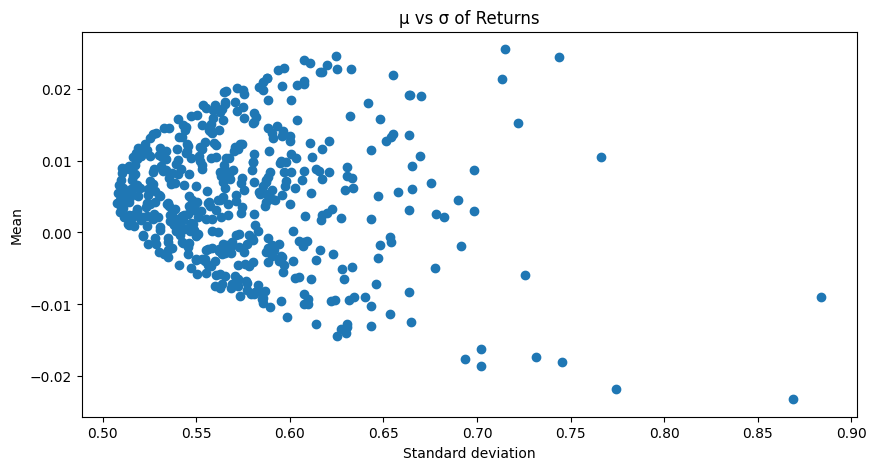

In [7]:
n_portfolios = 500

means, stds = np.column_stack([
    get_performance(returns) for _ in range(n_portfolios)
])

plt.figure(figsize=(10, 5))
plt.plot(stds, means, 'o')
plt.xlabel('Standard deviation')
plt.ylabel('Mean')
plt.title('μ vs σ of Returns')
plt.show()

The parabolic shape is called the ["Markowitz bullet"](https://en.wikipedia.org/wiki/Efficient_frontier), and the boundaries are called the ["efficient (or portfolio) frontier"](https://en.wikipedia.org/wiki/Efficient_frontier). 
The portfolios or stocks that are in the efficient frontier are the ones worth investing in because they give the highest return for a given standard deviation.

According to Markowitz's theory, there is an optimal way to balance getting the most returns with risk.
In the graph above, investors with an aggressive appetite in investing would choose stocks at the right side of the frontier.
Conservative investors, on the other hand, will choose stocks at the left side of the frontier. 

Now, we will try to calculate the efficient frontier. 

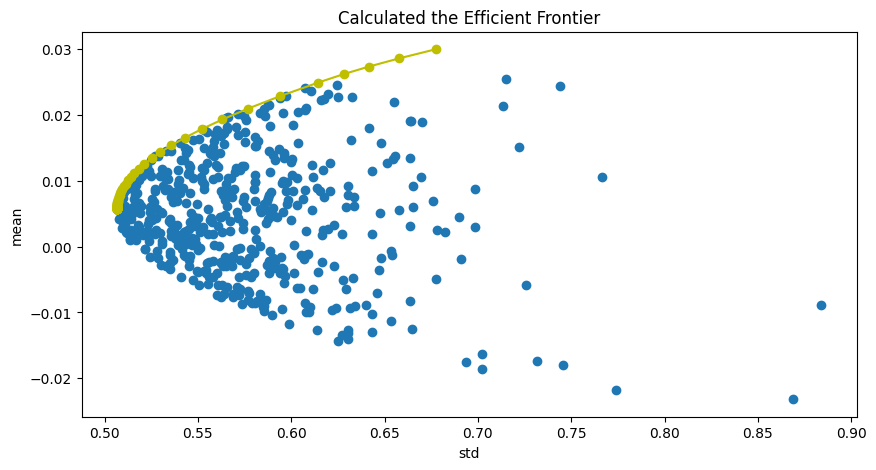

In [8]:
def get_optimal_portfolios(returns):
    n_assets = len(returns)
    mean_returns = np.mean(returns, axis=1).reshape(-1, 1)
    covar = np.asmatrix(np.cov(returns))

    # use cvxopt matrices
    covar = opt.matrix(covar)
    mean_returns = opt.matrix(mean_returns)

    # inequality constraints
    G = -opt.matrix(np.eye(n_assets))
    h = opt.matrix(0.0, (n_assets, 1))

    # equality constraints
    A = opt.matrix(1.0, (1, n_assets))
    b = opt.matrix(1.0)
    
    # get min and max returns
    N = 100
    mus = [10**(5 * t/N - 1) for t in range(N)]

    portfolios = [solvers.qp(mu*covar, -mean_returns, G, h, A, b)['x'] for mu in mus]
    wt = np.asarray([np.ravel(x) for x in portfolios])
    rets = np.asarray([blas.dot(mean_returns, x) for x in portfolios])
    risks = np.asarray([np.sqrt(blas.dot(x, covar*x)) for x in portfolios])

    return wt, rets, risks

weights, returns, risks = get_optimal_portfolios(returns)

plt.figure(figsize=(10, 5))
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
plt.title('The Efficient Frontier')
plt.show()

## Applying Theory on Real Stocks

## References

1. https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/?fbclid=IwY2xjawMo8clleHRuA2FlbQIxMQABHuyZdkuwk_uY9jgZoTi8l5EPdpAtEDekC4BmZpE0zILe1THV1r_8HoJgTA2K_aem_JoK2f6vaXhMcEpMEe0eu8Q
2. https://github.com/RichardS0268/Markowitz-Portfolio-theory
3. https://en.wikipedia.org/wiki/Efficient_frontier
4. https://www.fightfinance.com/resources/pricing/6h_markowitz_bullet_of_risky_assets.pdf
5. https://www.investopedia.com/terms/e/efficientfrontier.asp

The HM model is also called mean-variance model due to the fact that it is based on expected returns (mean) and the standard deviation (variance) of the various portfolios.